# FPI on 2D data (TSNE data from CIFAR10 dataset)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import os

import pickle
from filelock import FileLock

import io

import random 
import seaborn as sns
import numpy as np

def pickle_save(file, item):
    with open(file, 'wb') as fp:
        pickle.dump(item, fp)


def pickle_load(file):
    with FileLock(f'{file}.lck'):
        with open(file, 'r+b') as pfile:
            data = pickle.load(pfile)
            return data
        

def extract_and_split_data_based_on_labels(data, targets, cat=False):
    data_arr = []
    targets_arr = []
    all_classes = torch.unique(targets).tolist()
    for class_idx in all_classes:
        idx_i = (targets == class_idx).nonzero(as_tuple=False).flatten()
        data_i = data[idx_i]
        targets_i = targets[idx_i]

        data_arr.append(data_i)
        targets_arr.append(targets_i)

    if cat:
        data_arr = torch.cat(data_arr)
        targets_arr = torch.cat(targets_arr)

    return data_arr, targets_arr


def create_distribution(x_i_data):
    mean = torch.mean(x_i, dim=0)
    cov = torch.cov(x_i.t())
    var = torch.diag(cov)
    std = torch.sqrt(var)
    #std = torch.ones_like(std)
    
    distr = get_distribution(mean, std)
    return distr, (mean, var, std)

def get_distribution(mu, scale_tril):
    if len(mu.flatten()) != len(scale_tril.flatten()):
        distr = torch.distributions.MultivariateNormal(
            loc = mu,
            scale_tril = scale_tril
        )
    else:
        distr = torch.distributions.Independent(
            torch.distributions.Normal(mu, scale_tril), 1
        )
    return distr

def make_distribution_arr(mu_arr, std_arr):
    distr_arr = [get_distribution(elt_mu, elt_sigma) for elt_mu, elt_sigma in zip(mu_arr, std_arr)]
    return distr_arr


def get_plot_as_img():
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(io.BytesIO(buf.getvalue()))
    image = torchvision.transforms.ToTensor()(img).unsqueeze(0)
    image = image[0]
    return image

# Save the current image plotted with matplotlib to tensorboard
def save_to_tensorboard(trainer, file_grp, step, img=None, title=None):
    if title != None:
        plt.title(title)

    if img == None:
        img = get_plot_as_img()

    trainer.logger.experiment.add_image(file_grp, img, global_step=step)
    plt.clf()
    plt.cla()
    plt.close()
    sns.reset_defaults()

# Used to show images from a batch
def make_img_grid(imgs, nrows=8):
    is_int = imgs.dtype == torch.int32 if isinstance(imgs, torch.Tensor) else imgs[0].dtype == torch.int32
    imgs = torchvision.utils.make_grid(imgs, nrow=nrows, padding=2, pad_value=128 if is_int else 0.5)
    np_imgs = imgs.cpu().numpy()
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation="nearest")
    return imgs

def plot_and_sort_tensor(t, plot=False):
    plt.plot(t, label="not sorted")
    t_sort, ind = torch.sort(t)
    plt.plot(t_sort, label="sorted")
    plt.legend(loc="upper left")
    #plt.gca().set_box_aspect(1)
    #plt.gca().set_ylim(torch.min(t), torch.max(t))
    if plot:
        plt.plot()

# Scatter a list of points with different colors
def multi_scatter(arr, colors=["seagreen", "dodgerblue", "salmon"], title="Title", info_arr=None, xy_lim=None, ds_name="cifar10", plot_size=5):
    if len(arr) != len(colors):
        # Choose custom color in some cases
        colors = ["crimson", "coral", "gold", "seagreen", "turquoise", "dodgerblue", "slateblue", "violet", "pink", "chocolate"]
        # If there are still not enough, we pick them randomly
        if len(arr) > len(colors):
            colors = ["#"+''.join([random.choice('0123456789ABCDEF') 
                                  for j in range(6)])
                                  for i in range(len(arr))]

    # Fix if classes are stored in side of a dict ... 
    if isinstance(info_arr, dict):
        info_arr = [elt for elt in info_arr.keys()]

    for i, elt in enumerate(arr):
        if info_arr == None:
            plt.scatter(elt[:, 0], elt[:, 1], c=colors[i], alpha=0.5, s=plot_size)
        elif info_arr != None:
            plt.scatter(elt[:, 0], elt[:, 1], c=colors[i], alpha=0.5, s=plot_size, label="{}: {}".format(i, info_arr[i]))
            
            # To display the Jaccard index which is the last in the list
            if(len(info_arr) > len(arr)) and ((i+1) == len(arr)):
                plt.scatter(0, 0, c="black", alpha=0, label="%: {}".format(info_arr[-1]))
            
            
            plt.tight_layout()
            if ds_name in ["mnist", "fashionmnist", "cifar10"]:
                ax = plt.subplot(111)
                box = ax.get_position()
                ax.set_position([box.x0, box.y0, box.width * 1.0, box.height])
                # Put a legend to the right of the current axis
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title(title)
    
    # Set xlim and ylim to a certain range
    if xy_lim != None:
        plt.xlim(xy_lim)
        plt.ylim(xy_lim)


def plot_class_centroid(arr, ds, cfg):
    m_arr = [np.mean(elt, axis=0) for elt in arr]
    plt.gcf().set_size_inches(10, 10, forward=True)
    for m, name in zip(m_arr, ds):
        plt.scatter(m[0], m[1])

        if cfg["dataset_name"] in ["tinyimagenet", "imagenet"]:
            plt.annotate(name, (m[0], m[1]), fontsize=6, ha='center', va='center')
        else:
            plt.annotate(name, (m[0], m[1]), ha='center', va='center')






seed=0

# Step 1: Download CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Step 2: Extract data and labels from the dataset
train_data = trainset.data
train_labels = trainset.targets

# Step 3: Convert data to torch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.int64)

x = train_data_tensor.permute(0, 3, 1 ,2)
y = train_labels_tensor
x = x.reshape(x.shape[0], - 1)
num_classes = len(torch.unique(y))

tsne_cifar10_data_file = "tsne_cifar10_data_file.pickle"
if not os.path.isfile(tsne_cifar10_data_file):
    projector = TSNE(n_components=2, random_state=seed)
    x = torch.tensor(projector.fit_transform(x))
    data_dict = {
        "x": x,
        "y": y,
    }
    pickle_save(tsne_cifar10_data_file, data_dict)
else:
    for _ in range(2): print("Loading precalculated tsne data for cifar10")
    ds_dict = pickle_load(tsne_cifar10_data_file)
    x = ds_dict["x"]
    y = ds_dict["y"]

print("finished running this cell, run the next one")


Files already downloaded and verified
Loading precalculated tsne data for cifar10
Loading precalculated tsne data for cifar10
finished running this cell, run the next one


/tmp/ipykernel_2159124/469664213.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(classes))
/tmp/ipykernel_2159124/469664213.py:41: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in range(len(classes)): legend.legendHandles[i]._sizes = [legend_point_size]


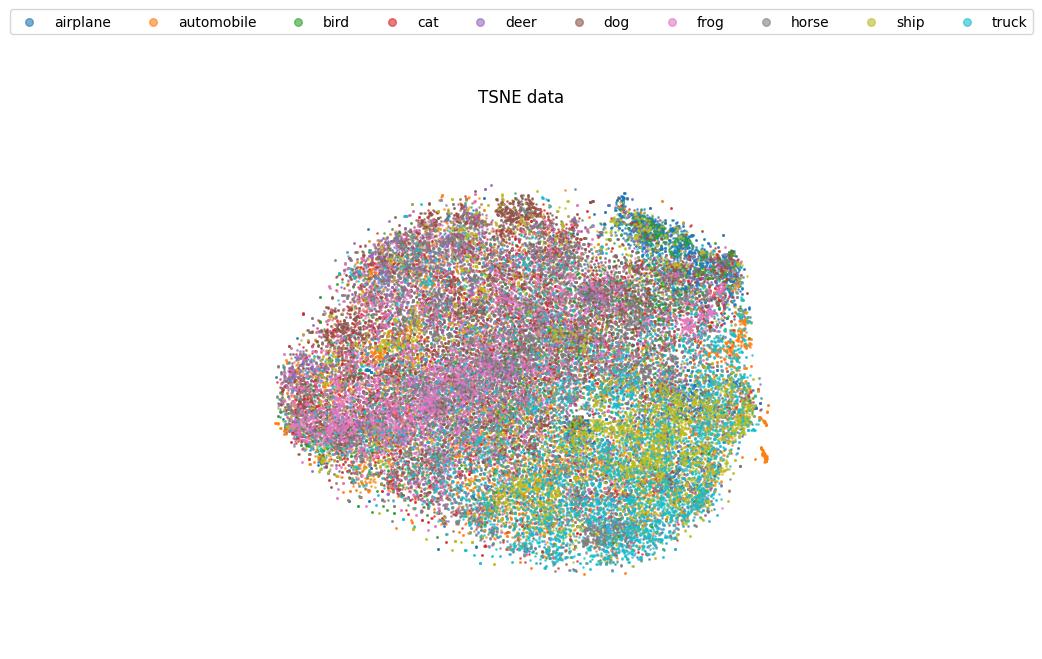

/tmp/ipykernel_2159124/469664213.py:59: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0]._sizes = [legend_point_size]


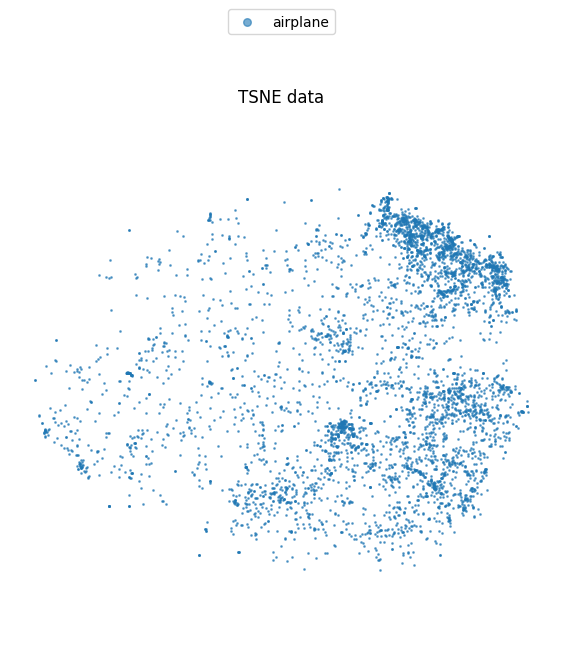

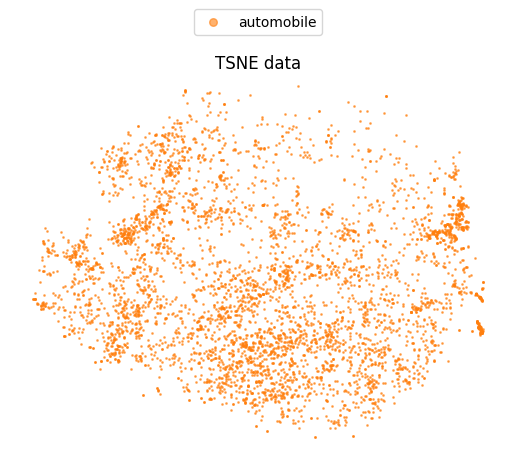

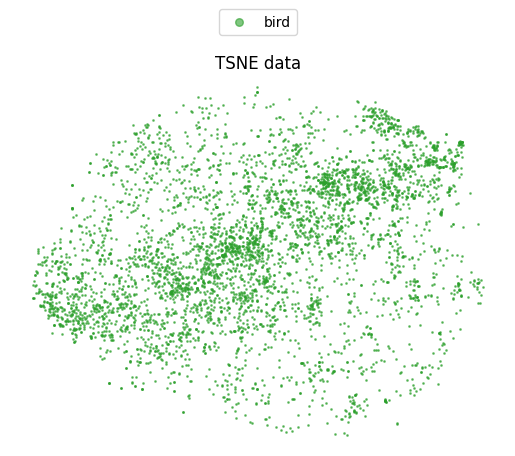

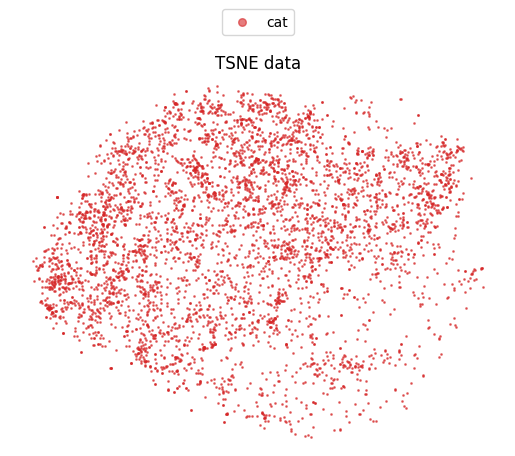

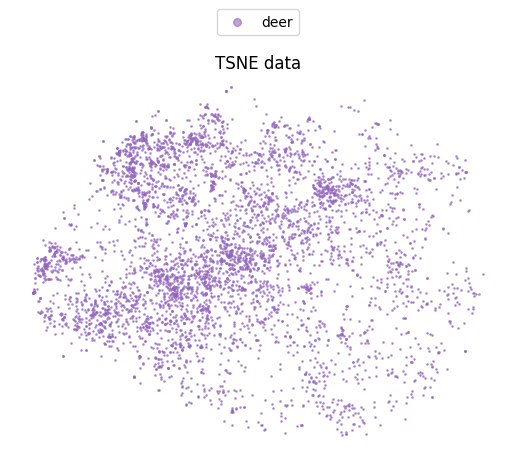

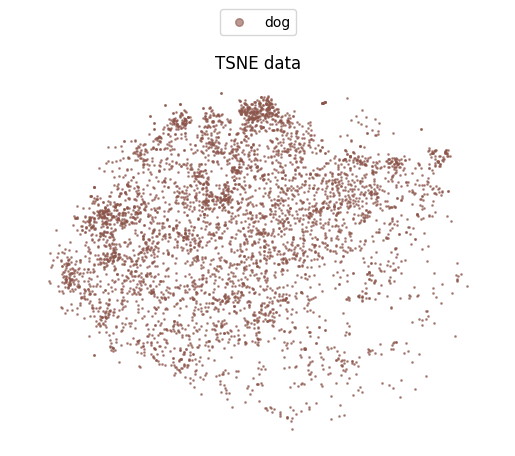

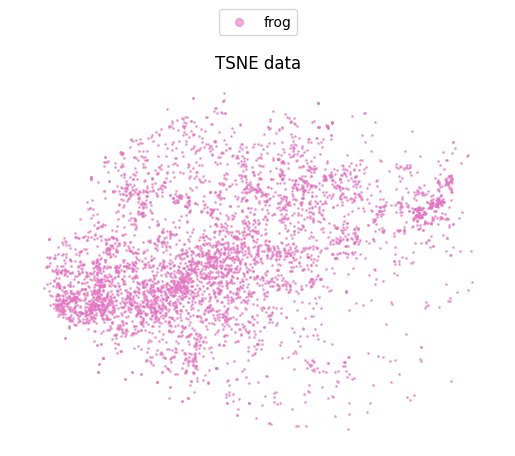

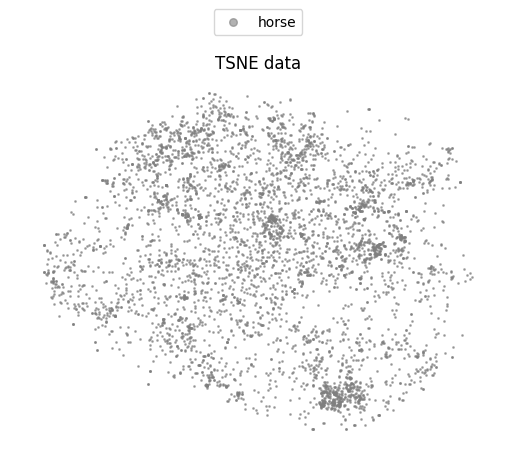

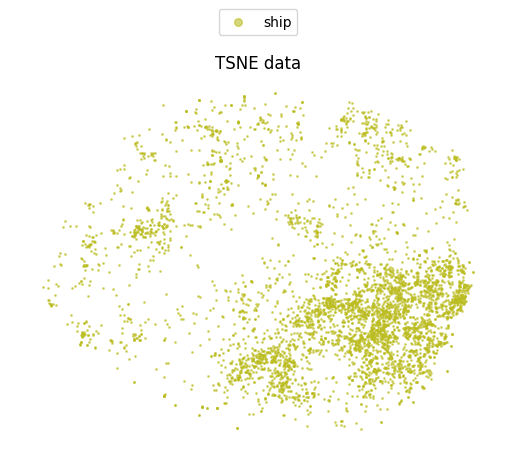

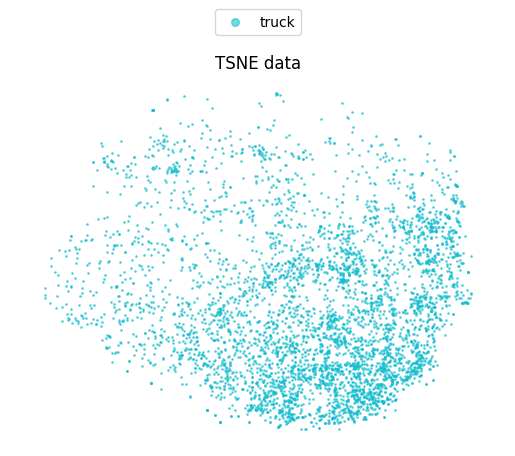

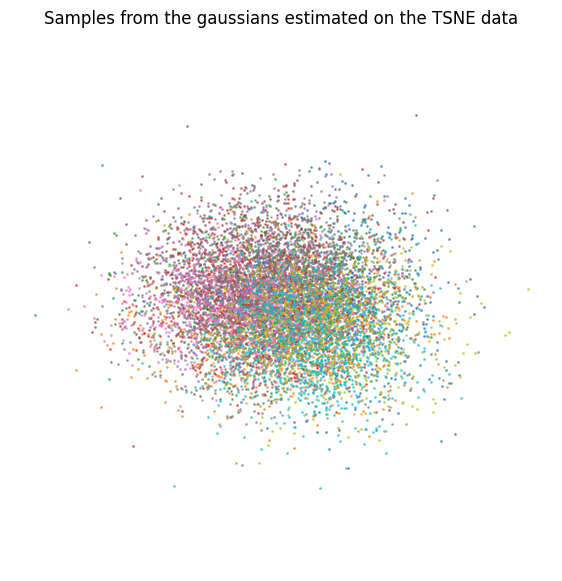

In [24]:
fs=7
dpi=None

# Estimate the gaussians from the TSNE data 
# ------------------------------------------------------------------------------------
x_arr = []
y_arr = []
mean_arr = []
var_arr = []
std_arr = []
distr_arr = []
for class_idx in range(num_classes):
    idx_i = (y == class_idx).nonzero(as_tuple=False).flatten()
    x_i = x[idx_i]
    y_i = y[idx_i]
    x_arr.append(x_i)
    y_arr.append(y_i)
    
    distr, distr_data = create_distribution(x_i)
    distr_arr.append(distr)
    
    mean, var, std = distr_data
    mean_arr.append(mean)
    var_arr.append(var)
    std_arr.append(std)

classes = trainset.classes
colors = plt.cm.get_cmap('tab10', len(classes))
# ------------------------------------------------------------------------------------


# Plot the TSNE data
# ------------------------------------------------------------------------------------
plt.figure(figsize=(fs, fs), dpi=dpi)
for i, (x_i, y_i) in enumerate(zip(x_arr, y_arr)):
    plt.scatter(x_i[:, 0], x_i[:, 1], label=classes[i], alpha=0.6, color=colors(i), s=1)
    
plt.title('TSNE of CIFAR10 training data')
legend = plt.legend(ncol=10, bbox_to_anchor=(0.5, 1.20), loc='upper center')
legend_point_size=30
for i in range(len(classes)): legend.legendHandles[i]._sizes = [legend_point_size]
plt.gca().set_aspect('equal', adjustable='datalim')

plt.title('TSNE data')
plt.gca().set_axis_off()
plt.savefig('tsne.png', bbox_inches='tight', pad_inches=0)
plt.show()
# ------------------------------------------------------------------------------------

# Plot the TSNE data
# ------------------------------------------------------------------------------------
plt.figure(figsize=(fs, fs), dpi=dpi)
for i, (x_i, y_i) in enumerate(zip(x_arr, y_arr)):
    plt.scatter(x_i[:, 0], x_i[:, 1], label=classes[i], alpha=0.6, color=colors(i), s=1)
    
    plt.title('TSNE of CIFAR10 training data')
    legend = plt.legend(ncol=10, bbox_to_anchor=(0.5, 1.20), loc='upper center')
    legend_point_size=30
    legend.legendHandles[0]._sizes = [legend_point_size]
    plt.gca().set_aspect('equal', adjustable='datalim')
    
    plt.title('TSNE data')
    plt.gca().set_axis_off()
    plt.savefig('tsne.png', bbox_inches='tight', pad_inches=0)
    plt.show()
# ------------------------------------------------------------------------------------


  
# Plot samples from the gaussians estimates from the TSNE data
# ------------------------------------------------------------------------------------
plt.figure(figsize=(fs, fs), dpi=dpi)
k=1000
for i, distr in enumerate(distr_arr):
    samples = distr.sample((k,),)
    plt.scatter(samples[:, 0], samples[:, 1], label=classes[i], alpha=0.6, color=colors(i), s=1)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.title('Samples from the gaussians estimated on the TSNE data')
plt.gca().set_axis_off()
plt.savefig('tsne_gaussians.png', bbox_inches='tight', pad_inches=0)
plt.show()
# ------------------------------------------------------------------------------------

This is the lambda_factor 1000
This is the kld factor 11.11111111111111
Train mu and sigma 1 1
10
10
10
10
10


Max diff mu 0.0753326416015625 -----  Max diff var 0.011888979002833366:   0%|          | 19/10000 [00:00<00:15, 643.54it/s]


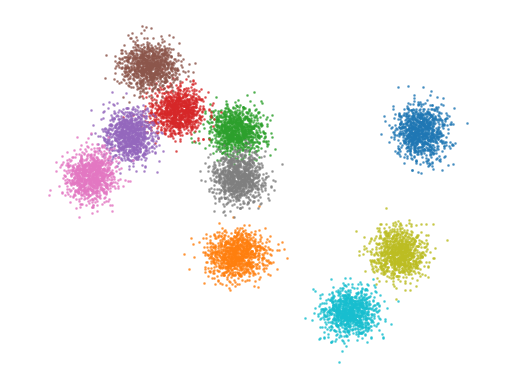

tensor([29.5829,  7.2368]) tensor([2.0127, 2.3452])
tensor([ -0.3314, -12.7519]) tensor([2.3698, 1.9250])
tensor([-0.5282,  7.4105]) tensor([2.1828, 1.9756])
tensor([-9.9851, 10.5418]) tensor([2.1808, 2.0299])
tensor([-17.7301,   6.7052]) tensor([2.0522, 2.0817])
tensor([-14.4790,  17.9426]) tensor([2.2516, 1.8988])
tensor([-23.9534,   0.0351]) tensor([2.0703, 2.0175])
tensor([ 0.0599, -0.2779]) tensor([2.1232, 2.0819])
tensor([ 25.9085, -12.5311]) tensor([2.0677, 2.0931])
tensor([ 17.9762, -22.0277]) tensor([2.1859, 1.9429])


In [ ]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import os

import pickle
from filelock import FileLock

import io

import random 
import seaborn as sns
import numpy as np


from PIL import Image

        
def extract_and_split_data_based_on_labels(data, targets, cat=False):
    data_arr = []
    targets_arr = []
    all_classes = torch.unique(targets).tolist()
    for class_idx in all_classes:
        idx_i = (targets == class_idx).nonzero(as_tuple=False).flatten()
        data_i = data[idx_i]
        targets_i = targets[idx_i]

        data_arr.append(data_i)
        targets_arr.append(targets_i)

    if cat:
        data_arr = torch.cat(data_arr)
        targets_arr = torch.cat(targets_arr)

    return data_arr, targets_arr


def create_distribution(x_i_data):
    mean = torch.mean(x_i, dim=0)
    cov = torch.cov(x_i.t())
    var = torch.diag(cov)
    std = torch.sqrt(var)
    #std = torch.ones_like(std)
    
    distr = get_distribution(mean, std)
    return distr, (mean, var, std)

def get_distribution(mu, scale_tril):
    if len(mu.flatten()) != len(scale_tril.flatten()):
        distr = torch.distributions.MultivariateNormal(
            loc = mu,
            scale_tril = scale_tril
        )
    else:
        distr = torch.distributions.Independent(
            torch.distributions.Normal(mu, scale_tril), 1
        )
    return distr


def make_distribution_arr(mu_arr, std_arr):
    distr_arr = [get_distribution(elt_mu, elt_sigma) for elt_mu, elt_sigma in zip(mu_arr, std_arr)]
    return distr_arr


def get_plot_as_img():
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    img = Image.open(io.BytesIO(buf.getvalue()))
    image = torchvision.transforms.ToTensor()(img).unsqueeze(0)
    image = image[0]
    return image

# Save the current image plotted with matplotlib to tensorboard
def save_to_tensorboard(logger, file_grp, step, img=None, title=None):
    if title != None:
        plt.title(title)

    if img == None:
        img = get_plot_as_img()

    logger.experiment.add_image(file_grp, img, global_step=step)
    plt.clf()
    plt.cla()
    plt.close()
    sns.reset_defaults()

# Used to show images from a batch
def make_img_grid(imgs, nrows=8):
    is_int = imgs.dtype == torch.int32 if isinstance(imgs, torch.Tensor) else imgs[0].dtype == torch.int32
    imgs = torchvision.utils.make_grid(imgs, nrow=nrows, padding=2, pad_value=128 if is_int else 0.5)
    np_imgs = imgs.cpu().numpy()
    plt.imshow(np.transpose(np_imgs, (1, 2, 0)), interpolation="nearest")
    return imgs

def plot_and_sort_tensor(t, plot=False):
    plt.plot(t, label="not sorted")
    t_sort, ind = torch.sort(t)
    plt.plot(t_sort, label="sorted")
    plt.legend(loc="upper left")
    #plt.gca().set_box_aspect(1)
    #plt.gca().set_ylim(torch.min(t), torch.max(t))
    if plot:
        plt.plot()

# Scatter a list of points with different colors
def multi_scatter(arr, colors=["seagreen", "dodgerblue", "salmon"], title="Title", info_arr=None, xy_lim=None, ds_name="cifar10", plot_size=5):
    if len(arr) != len(colors):
        # Choose custom color in some cases
        colors = ["crimson", "coral", "gold", "seagreen", "turquoise", "dodgerblue", "slateblue", "violet", "pink", "chocolate"]
        # If there are still not enough, we pick them randomly
        if len(arr) > len(colors):
            colors = ["#"+''.join([random.choice('0123456789ABCDEF') 
                                  for j in range(6)])
                                  for i in range(len(arr))]

    # Fix if classes are stored in side of a dict ... 
    if isinstance(info_arr, dict):
        info_arr = [elt for elt in info_arr.keys()]

    for i, elt in enumerate(arr):
        if info_arr == None:
            plt.scatter(elt[:, 0], elt[:, 1], c=colors[i], alpha=0.5, s=plot_size)
        elif info_arr != None:
            plt.scatter(elt[:, 0], elt[:, 1], c=colors[i], alpha=0.5, s=plot_size, label="{}: {}".format(i, info_arr[i]))
            
            # To display the Jaccard index which is the last in the list
            if(len(info_arr) > len(arr)) and ((i+1) == len(arr)):
                plt.scatter(0, 0, c="black", alpha=0, label="%: {}".format(info_arr[-1]))
            
            
            plt.tight_layout()
            if ds_name in ["mnist", "fashionmnist", "cifar10"]:
                ax = plt.subplot(111)
                box = ax.get_position()
                ax.set_position([box.x0, box.y0, box.width * 1.0, box.height])
                # Put a legend to the right of the current axis
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title(title)
    
    # Set xlim and ylim to a certain range
    if xy_lim != None:
        plt.xlim(xy_lim)
        plt.ylim(xy_lim)


def plot_class_centroid(arr, ds):
    m_arr = [np.mean(elt, axis=0) for elt in arr]
    plt.gcf().set_size_inches(10, 10, forward=True)
    for m, name in zip(m_arr, ds):
        plt.scatter(m[0], m[1])
        plt.annotate(name, (m[0], m[1]), ha='center', va='center')



import torch
from torch import nn

import os 
import sys
import copy
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE



def kl_div(mu_q, std_q, mu_p, std_p):
    """
    Computes the KL divergence between the two given variational distribution.\
    This computes KL(q||p), which is not symmetric. It quantifies how far is\
    The estimated distribution q from the true distribution of p.
    
    
    Taken from: https://discuss.pytorch.org/t/how-to-efficiently-compute-a-pairwise-kl-divergence-matrix-of-a-batch-of-gaussian-distributions/192519/3
    """
    k = mu_q.size(-1)
    mu_diff = mu_p - mu_q
    mu_diff_sq = torch.mul(mu_diff, mu_diff)
    logdet_std_q = torch.sum(2 * torch.log(torch.clamp(std_q, min=1e-8)), dim=-1)
    logdet_std_p = torch.sum(2 * torch.log(torch.clamp(std_p, min=1e-8)), dim=-1)
    fs = torch.sum(torch.div(std_q**2, std_p**2), dim=-1) + torch.sum(
        torch.div(mu_diff_sq, std_p**2), dim=-1
    )
    kl_divergence = (fs - k + logdet_std_p - logdet_std_q) * 0.5
    return kl_divergence

def get_pairwise_kld_losses(mu_arr, scale_tril_arr):
    with torch.no_grad():
        n_gaussians = len(mu_arr)
        device_ = mu_arr[0].device
        mu_arr.requires_grad=False
        scale_tril_arr.requires_grad=False
        
        if mu_arr[0].shape == scale_tril_arr[0].shape:
            K = len(mu_arr)
            D = len(mu_arr[0])
            chunk_size=100
            if chunk_size > K:
                chunk_size = K
            chunk_ratio = K // chunk_size
            mu = torch.stack([elt.detach().clone() for elt in mu_arr])
            std = torch.stack([elt.detach().clone() for elt in scale_tril_arr])

            kld_loss_detach_arr = []
            for c1 in range(chunk_ratio):
                c1_start = c1 * chunk_size
                c1_end = (c1 + 1) * chunk_size
                temp_kld_loss_detach_arr = []
                for c2 in range(chunk_ratio):
                    c2_start = c2 * chunk_size
                    c2_end = (c2 + 1) * chunk_size

                    mu_p1 = mu[c1_start:c1_end]
                    std_p1 = std[c1_start:c1_end]
                    
                    mu_p2 = mu[c2_start:c2_end]
                    std_p2 = std[c2_start:c2_end]

                    kld_loss = kl_div(mu_p1.unsqueeze(1), std_p1.unsqueeze(1), mu_p2.unsqueeze(0), std_p2.unsqueeze(0))
                    kld_loss_detach = kld_loss.detach().clone()
                    temp_kld_loss_detach_arr.append(kld_loss_detach)
                                    
                temp_kld_loss_detach_arr = torch.cat(temp_kld_loss_detach_arr, dim=1)
                kld_loss_detach_arr.append(temp_kld_loss_detach_arr)
            kld_loss_detach_arr = torch.cat(kld_loss_detach_arr, dim=0)

            return kld_loss_detach_arr
        
        else:
            distr_list  = [
                get_distribution(mu_arr[i], scale_tril_arr[i])
                for i in range(n_gaussians)
            ]
                
            kld_list = [
                torch.distributions.kl.kl_divergence(
                    distr_list[i], distr_list[j]
                )
                for i in range(n_gaussians) for j in range(n_gaussians)
            ]
            
            kld_tensor = torch.tensor(kld_list).to(device_)
            kld_tensor = kld_tensor.reshape(n_gaussians, n_gaussians)
            
            return kld_tensor


def remove_diagonal_elements(M):
    return M[~torch.eye(*M.shape,dtype = torch.bool)]

def nan_sys_exit(tensor, msg):
    if torch.isnan(tensor).any():
        sys.exit(msg)

def replace_last_dim_with_mean(tensor):
    shape_size = len(tensor.shape)
    shape = torch.ones(shape_size-1).to(torch.int64).tolist()
    shape.append(tensor.shape[-1])
    tensor = torch.mean(tensor, dim=-1, keepdim=True).repeat(*shape)
    return tensor

def add_Id(mat, eps=1e-7):
    Id = torch.eye(mat.shape[0]).to(mat.device)
    mat = mat + Id * eps
    return mat


class FPI(nn.Module):
    def __init__(self, data, labels, mean_arr=None, var_arr=None, classes_list=None, lambda_val=10000, eps=1e-1, max_iters=10000, train_mu=1, train_sigma=1, force_isotropic=0.0, use_isotropic_variance_when_training_mean=0, sum_mu_diffs_arr_square=0, dtype=torch.float32, plt_show=False):
        super().__init__()

        """
        # Abreviations used
        bs = batch_size
        ch, h, w = channel, height, width
        dim = dimension of the data in 1d
        num_classes = number of distinct labels (should be equal to len(torch.unique(labels)))
        
        
        data:   torch.Tensor containing all the data                   shape [bs, ch, h, w] for instance
        labels: torch.Tensor containing all the labels for the data of shape [bs] 
        mean_arr: list or tensor containing all the current means of the generative model of shape [num_classes, dim]
        mean_arr: list or tensor containing all the current variances of the generative model of shape [num_classes, dim]

        Code needs one of these two variants to run (even if default is None)
        """

        # Calculate data mean and variance
        # --------------------------------------------------------------------------------
        self.og_shape = data.shape
        data = data.reshape(data.shape[0], -1)

        x_arr, y_arr = extract_and_split_data_based_on_labels(data, labels)
        data_mean_arr = [torch.mean(elt, dim=0) for elt in x_arr]
        data_var_arr  = [torch.var(elt, dim=0) for elt in x_arr]

        # Set mean and var equal to the data if it is none
        mean_arr = copy.deepcopy(data_mean_arr) if (mean_arr == None) else mean_arr
        var_arr  = copy.deepcopy(data_var_arr)  if (var_arr == None ) else var_arr
        # --------------------------------------------------------------------------------
        
        self.classes_list = classes_list
        self.lambda_val = lambda_val
        self.eps = eps
        self.max_iters = max_iters
        self.use_isotropic_variance_when_training_mean = use_isotropic_variance_when_training_mean
        self.force_isotropic = force_isotropic
        self.sum_mu_diffs_arr_square = sum_mu_diffs_arr_square
        self.dtype=dtype
        self.plt_show=plt_show

        self.train_mu = train_mu
        self.train_sigma = train_sigma

        #  We force isotropic variance, and we no longer train them
        if self.force_isotropic > 0.0:
            data_var_arr = [torch.ones_like(elt) * self.force_isotropic for elt in data_var_arr]
            var_arr = copy.deepcopy(data_var_arr)
            self.train_sigma = 0

        self.num_classes = len(mean_arr)
        self.kld_factor = self.lambda_val / ((self.num_classes) * (self.num_classes - 1))
        if self.classes_list == None:
            self.classes_list = torch.arange(self.num_classes)

        self.data_mean_arr = nn.ParameterList([
            nn.Parameter(torch.clone(elt).to(self.dtype), requires_grad=False) for elt in data_mean_arr
        ])
        self.data_var_arr = nn.ParameterList([
            nn.Parameter(torch.clone(elt).to(self.dtype), requires_grad=False) for elt in data_var_arr
        ])

        self.mean_arr = nn.ParameterList([
            nn.Parameter(torch.clone(elt).to(self.dtype), requires_grad=False) for elt in mean_arr
        ])
        self.var_arr = nn.ParameterList([
            nn.Parameter(torch.clone(elt).to(self.dtype), requires_grad=False) for elt in var_arr
        ])
        self.std_arr = nn.ParameterList([
            nn.Parameter(torch.sqrt(torch.clone(elt)).to(self.dtype), requires_grad=False) for elt in var_arr
        ])

        print("This is the lambda_factor", self.lambda_val)
        print("This is the kld factor", self.kld_factor)
        print("Train mu and sigma", self.train_mu, self.train_sigma)

        print(len(self.data_mean_arr))
        print(len(self.data_var_arr))
        print(len(self.mean_arr))
        print(len(self.var_arr))
        print(len(self.std_arr))
        


    def calculate_K_arr_and_tau_arr(self, alpha=10):
        with torch.no_grad():
            pw_kld = get_pairwise_kld_losses(self.mean_arr, self.std_arr)
            pw_kld_scale = pw_kld * alpha
            K_arr = torch.exp(-pw_kld / pw_kld_scale) / pw_kld_scale
            K_arr = K_arr.fill_diagonal_(0.0) # Remove nan from zero division on the diagonal
            tau_arr = self.kld_factor * (K_arr - K_arr.t()).sum(dim=1) # division by the number of classes in already in the kld_factor
            return K_arr, tau_arr
        
    def update_gaussian_params_arr_idx(self, idx, mu, cov, eps=None):
        mu = mu.data
        cov = cov.data
        
        if len(cov.shape) > 1: # we have a dense covariance matrix
            if (eps != None):
                cov = add_Id(cov, eps)                
            scale_tril = torch.linalg.cholesky(cov)
        else: 
            scale_tril = torch.sqrt(cov)
        
        mu = mu.to(self.dtype)
        cov = cov.to(self.dtype)
        scale_tril = scale_tril.to(self.dtype)

        self.mean_arr[idx] = nn.Parameter(mu, requires_grad=False)
        self.var_arr[idx] = nn.Parameter(cov, requires_grad=False)
        self.std_arr[idx] = nn.Parameter(scale_tril, requires_grad=False)


    def run(self, logger=None, step=0, i_samples=3):

        num_classes = self.num_classes
        dtype = self.dtype

        with torch.no_grad():
            for repet_idx in (pbar := tqdm(range(self.max_iters))):
                K_arr, tau_arr  = self.calculate_K_arr_and_tau_arr()
                K_arr = torch.clone(K_arr)
                tau_arr = torch.clone(tau_arr)

                data_mean_arr = torch.stack([torch.clone(self.data_mean_arr[i]) for i in range(num_classes)])
                data_var_arr = torch.stack([torch.clone(self.data_var_arr[i]) for i in range(num_classes)])

                mu_clone = torch.stack([torch.clone(self.mean_arr[i]).to(dtype) for i in range(num_classes)])
                var_clone = torch.stack([torch.clone(self.var_arr[i]).to(dtype) for i in range(num_classes)])
                var_inv_clone = torch.stack([1 / elt.to(dtype) for elt in var_clone ])

                # (k * k * d) matrix
                # Each row is the difference between mu_i - m_j (that's why using transpose)
                mu_diffs_arr = torch.transpose(torch.stack([
                    mu_clone - mu_clone[class_idx]
                    for class_idx in range(num_classes)
                ]), 0, 1)
                
                # (k * k * d) matrix
                # Each row is the diagonal of the outer product of  (mu_i - m_j) (mu_i - m_j)^{T) (also sums along j)
                mu_diffs_arr_square = torch.square(mu_diffs_arr)
                if self.sum_mu_diffs_arr_square:
                    # Trick to make obtnain smaller variances if desired
                    mu_diffs_arr_square = mu_diffs_arr_square.sum(dim=1)

                # (k * k * d) matrix  # Each row is the variance for i to j
                var_clone_arr = torch.stack([ var_clone for _ in range(num_classes)])
                # (k * k * d) matrix # Each row is the inverse of variance i to j
                var_inv_arr = torch.stack([ var_inv_clone for _ in range(num_classes)])


                # Fixed point iteration calculations for all the means 
                # ----------------------------------------------------------------
                # (k * k * 1) matrix
                K_ij = torch.clone(K_arr).unsqueeze(-1)
                K_ji = torch.transpose(torch.clone(K_ij), 0, 1)

                if self.train_mu:
                    c_var_inv_arr = torch.clone(var_inv_arr)
                    c_var_clone = torch.clone(var_clone)

                    # Replace variance with mean to stabilize ... (avoids spiking mean amplitude on a single dimension when labmda is high)
                    if self.use_isotropic_variance_when_training_mean:
                        c_var_inv_arr = replace_last_dim_with_mean(c_var_inv_arr) 
                        c_var_clone = replace_last_dim_with_mean(c_var_clone) 
    
                    kld_mu = (K_ij * c_var_inv_arr) + (K_ji * torch.transpose(c_var_inv_arr, 0, 1))
                    kld_mu = kld_mu * mu_diffs_arr
                    kld_mu = torch.sum(kld_mu, dim=1)
                    kld_mu = c_var_clone * kld_mu
                    mu_new = data_mean_arr + self.kld_factor * kld_mu

                else:
                    max_diff_mu = 0
                    mu_new  = torch.clone(mu_clone)
                # ----------------------------------------------------------------

                
                # Fixed point iteration calculations for sigma
                # ----------------------------------------------------------------
                # (k * k * 1) matrix
                if self.train_sigma:
                    B = + data_var_arr \
                        + self.kld_factor  * var_clone * torch.sum(K_ij * var_inv_arr, dim=1) * var_clone
                    

                    A = var_clone * (
                        + (1 + tau_arr.unsqueeze(-1)) * var_inv_clone \
                        + self.kld_factor * var_inv_clone * torch.sum(K_ji * mu_diffs_arr_square,  dim=1) * var_inv_clone \
                        + self.kld_factor * var_inv_clone * torch.sum(K_ji * var_clone_arr, dim=1) * var_inv_clone
                    ) * var_clone

                    BA = B*A
                    BA_05 = torch.pow(BA, 0.5)
                    var_new = BA_05 * (1/A)
                        
                else:
                    max_diff_var = 0
                    var_new = torch.clone(var_clone)
                # ----------------------------------------------------------------
                
                diff_mu = mu_clone - mu_new
                diff_var = var_clone - var_new

                max_norm2_mu = torch.max(torch.norm(diff_mu, dim=1, p=2))
                max_norm2_var = torch.max(torch.norm(diff_var, dim=1, p=2))

                max_diff_mu = max_norm2_mu
                max_diff_var = max_norm2_var

                nan_sys_exit(max_diff_mu, "nan max diff mu")
                nan_sys_exit(max_diff_var, "nan max diff var")

                for class_idx in range(num_classes):
                    self.update_gaussian_params_arr_idx(class_idx, mu_new[class_idx], var_new[class_idx], None)

                pbar.set_description(f"Max diff mu {max_diff_mu} -----  Max diff var {max_diff_var}")


                if ((max_diff_mu <= self.eps) and (max_diff_var <= self.eps)):
                    break
            
            distr_arr = [get_distribution(
                torch.clone(self.mean_arr[i]), torch.clone(self.std_arr[i]))  
                for i in range(self.num_classes)
            ]



            if (logger != None ) or (self.plt_show):

                # Plot pairwise minimal kld factors
                k = num_classes * (num_classes - 1)


                pw_kld = remove_diagonal_elements(
                    get_pairwise_kld_losses(self.mean_arr, self.std_arr)
                )

                prefix="www_"
                min_kld, max_kld, mean_kld = torch.min(pw_kld).item(), torch.max(pw_kld).item(), torch.mean(pw_kld).item()
                if logger != None:
                    logger.experiment.add_scalars(f"{prefix}_kld_and_acc_info",{
                        "min_kld": min_kld,
                        "max_kld": max_kld,
                        "mean_kld": mean_kld
                    }, global_step=step)



                top_k_pw, _ = torch.topk(pw_kld, k=k, largest=False)
                plt.plot(top_k_pw.cpu())
                TASK_ID = f"{prefix}_pairwise_kld_factors_{k}"
                save_to_tensorboard(logger, file_grp=TASK_ID, step=step, img=None, title=None) if not self.plt_show else plt.show()



                # Sample noise to plot the TSNE
                if self.num_classes <= 100:
                    bs = 64
                else:
                    bs = 2

                noise = torch.cat([distr.sample((bs,),) for distr in distr_arr])
                

                noise_emb = TSNE(n_components=2, verbose=0, random_state=0).fit_transform(noise.detach().cpu())
                noise_emb = np.array_split(noise_emb, self.num_classes)

                multi_scatter(noise_emb, info_arr=self.classes_list)
                TASK_ID = f"{prefix} tsne noise"
                save_to_tensorboard(logger, file_grp=TASK_ID, step=step, img=None, title=None) if not self.plt_show else plt.show()

                #print("this is plt_show", self.plt_show)
                plot_class_centroid(noise_emb, self.classes_list)
                TASK_ID = f"{prefix} tsne noise names"
                save_to_tensorboard(logger, file_grp=TASK_ID, step=step, img=None, title=None) if not self.plt_show else plt.show()


                prefix="yyy_"
                for i, mean in enumerate(self.mean_arr):
                    if i < i_samples:
                        TASK_ID = f"{prefix}_mu_plot_{i}"
                        plot_and_sort_tensor(mean.clone().detach().cpu(), plot=False)
                        save_to_tensorboard(logger, file_grp=TASK_ID, step=step, img=None, title=None) if not self.plt_show else plt.show()
                
                for i, var in enumerate(self.var_arr):
                    if i < i_samples:
                        TASK_ID = f"{prefix}_var_plot_{i}"
                        plot_and_sort_tensor(var.clone().detach().cpu(), plot=False)
                        save_to_tensorboard(logger, file_grp=TASK_ID, step=step, img=None, title=None) if not self.plt_show else plt.show()

            return distr_arr


    def copy_params_to(self, target_mean_arr, target_var_arr, target_std_arr):
        for i in range(self.num_classes):
            target_mean_arr[i] = nn.Parameter(torch.clone(self.mean_arr[i]), requires_grad=False)
            target_var_arr[i] = nn.Parameter(torch.clone(self.var_arr[i]), requires_grad=False)
            target_std_arr[i] = nn.Parameter(torch.clone(self.std_arr[i]), requires_grad=False)



# Directly run the FPI on the training data
# In this case there are no gaussian parameters from the generative model (mean_arr = None, var_arr = None), but they could provided

#lambda_val=100
lambda_val=1000
#lambda_val=5000
#lambda_val=10000
#lambda_val=50000
#lambda_val=100000
train_mu=1
train_sigma=1
force_isotropic=0.0
use_isotropic_variance_when_training_mean=1
sum_mu_diffs_arr_square=0
fpi = FPI(
    data=x, labels=y,
    mean_arr=None, var_arr=None,
    lambda_val=lambda_val,
    train_mu=train_mu, train_sigma=train_sigma,
    force_isotropic=force_isotropic,
    use_isotropic_variance_when_training_mean=use_isotropic_variance_when_training_mean,
    sum_mu_diffs_arr_square=sum_mu_diffs_arr_square,
)
distr_arr = fpi.run()

l = len(fpi.mean_arr)
good_mean_arr = [fpi.mean_arr[i].clone() for i in range(l)]
good_std_arr = [fpi.std_arr[i].clone() for i in range(l)]
distr_arr = [get_distribution(mean_i, std_i) for i, (mean_i, std_i) in enumerate(zip(good_mean_arr, good_std_arr))]

for i, distr in enumerate(distr_arr):
    samples = distr.sample((k,),)
    plt.scatter(samples[:, 0], samples[:, 1], label=classes[i], alpha=0.6, color=colors(i), s=1)
plt.gca().set_aspect('equal', adjustable='datalim')
plt.title('')
plt.gca().set_axis_off()
plt.savefig(f"fpi_{lambda_val}.png", bbox_inches='tight', pad_inches=0)
plt.show()

for i, (mean_i, std_i) in enumerate(zip(good_mean_arr, good_std_arr)):
    print(mean_i, std_i)


